In [72]:
# Importing essential libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style for plots
sns.set(style="whitegrid")


In [73]:
# Load the dataset with low_memory=False to avoid dtype warnings
file_path = 'C:/ML/Dataset/Amazon Sale Report.csv'
data = pd.read_csv(file_path, low_memory=False)

# Display basic information and check initial rows
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [75]:
# Drop unnecessary columns
data.drop(columns=['index', 'promotion-ids', 'Unnamed: 22', 'fulfilled-by', 'SKU', 'ASIN', 'ship-city', 'ship-state', 'ship-country'], inplace=True, errors='ignore')

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Fill missing values in 'Amount' and 'currency'
data['Amount'].fillna(data['Amount'].median(), inplace=True)
data['currency'].fillna('INR', inplace=True)

# Drop rows where 'Date' is missing
data.dropna(subset=['Date'], inplace=True)

# Convert relevant object columns to categorical
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].astype('category')


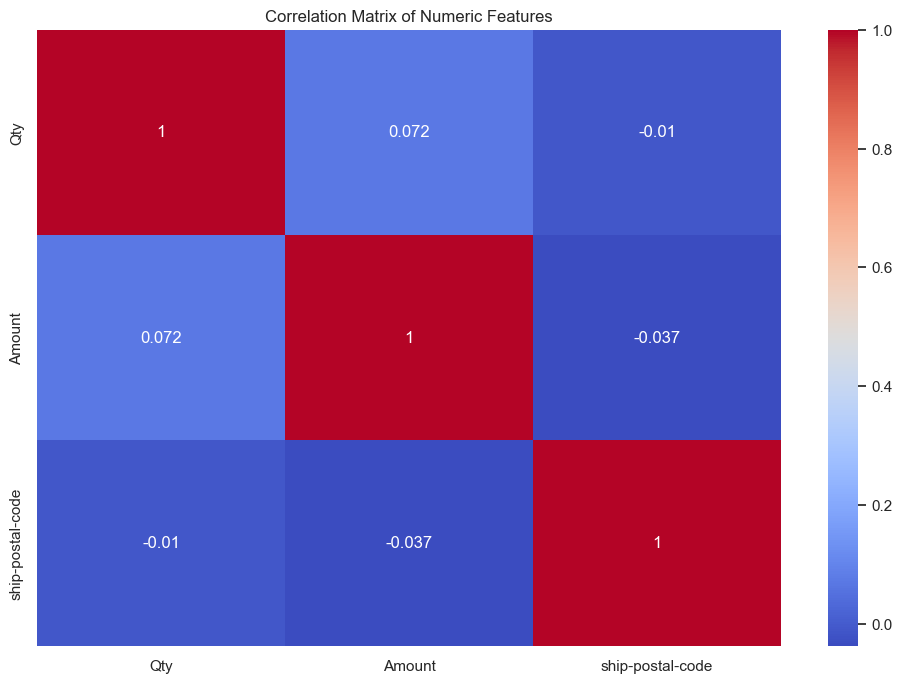

In [76]:
# Select only numeric columns for the correlation matrix
numeric_data = data.select_dtypes(include=[float, int])

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()


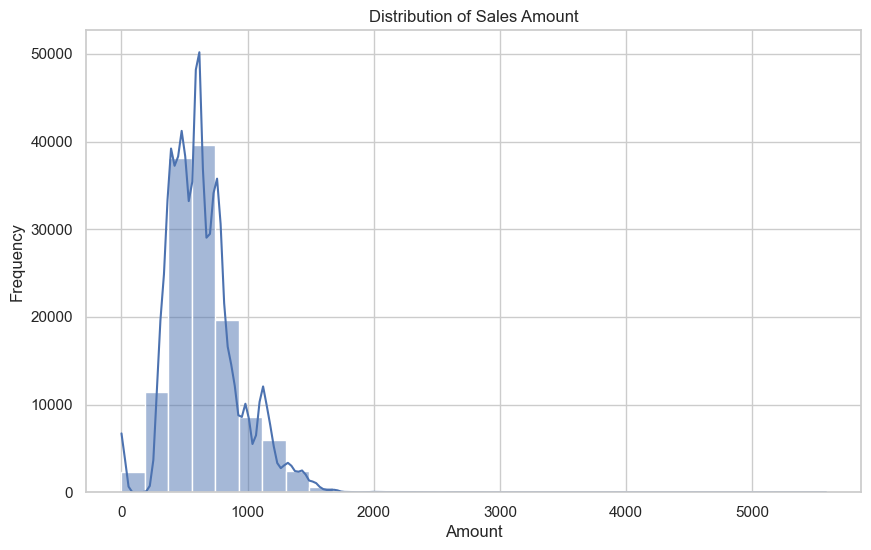

In [77]:
# Plot the distribution of the target variable 'Amount'
plt.figure(figsize=(10, 6))
sns.histplot(data['Amount'], bins=30, kde=True)
plt.title('Distribution of Sales Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


In [78]:
# Extract month and day from 'Date' to capture seasonal patterns
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day


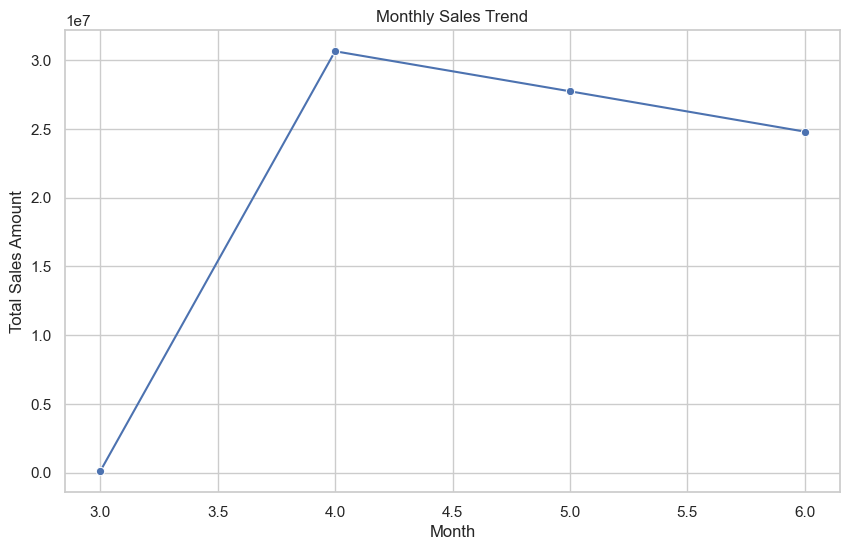

In [79]:
# Ensure month column is created
data['month'] = data['Date'].dt.month

# Monthly sales trend to check for seasonality
monthly_sales = data.groupby('month')['Amount'].sum()
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.show()


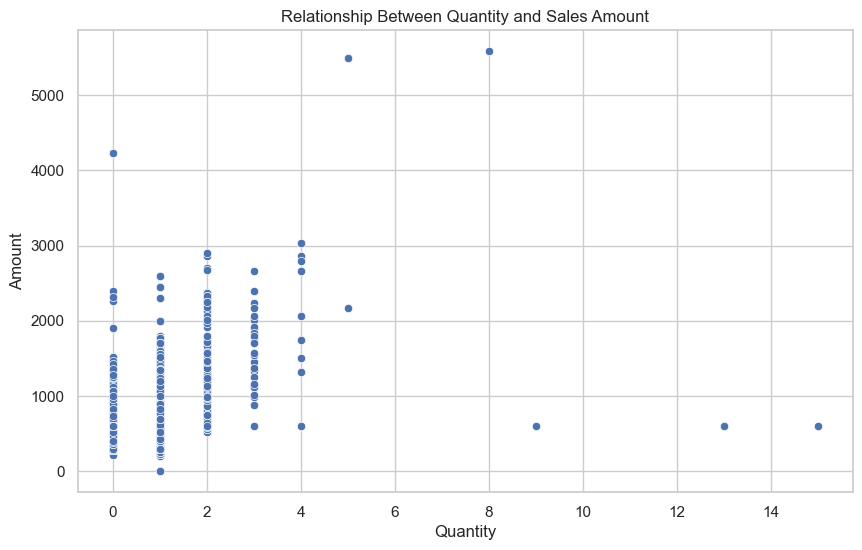

In [80]:
# Scatter plot to explore the relationship between Quantity and Sales Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Qty', y='Amount')
plt.title('Relationship Between Quantity and Sales Amount')
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.show()


In [81]:
# Enhanced feature engineering
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['day_of_week'] = data['Date'].dt.dayofweek
data['quarter'] = data['Date'].dt.quarter
data['sales_lag_1'] = data['Qty'].shift(1).fillna(data['Qty'].mean())
data['rolling_mean_sales'] = data['Qty'].rolling(window=3).mean().fillna(data['Qty'].mean())


In [82]:
# Extract month and day from 'Date' to capture seasonal patterns
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day

# Add a holiday season indicator for November and December
data['is_holiday_season'] = data['month'].apply(lambda x: 1 if x in [11, 12] else 0)

# Create a sales lag feature, representing sales quantity from the previous record
data['sales_lag_1'] = data['Qty'].shift(1)
data['sales_lag_1'].fillna(data['Qty'].mean(), inplace=True)


In [83]:
# Select categorical columns for dummy encoding
categorical_columns = ['Status', 'Fulfilment', 'Sales Channel ', 'ship-service-level', 'Style', 'Category']

# Convert categorical columns to dummy variables
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)


In [84]:
# Define target variable as 'Amount' and drop unnecessary columns for modeling
target_column = 'Amount'
feature_columns = data.drop(columns=['Order ID', 'Date', target_column], errors='ignore')

# Define X (features) and y (target)
X = feature_columns
y = data[target_column]


In [85]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
# Define a function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2): {r2}")
    return mae, rmse, r2


In [87]:
# Replace spaces with underscores in feature names for both train and test sets
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')


In [88]:
# Convert all categorical features to integer codes for XGBoost compatibility
for col in X_train.select_dtypes(include='category').columns:
    X_train[col] = X_train[col].cat.codes
    X_test[col] = X_test[col].cat.codes

# Updated function to train and evaluate the XGBoost model
def train_xgboost(X_train, y_train, X_test, y_test):
    xgb_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=6, subsample=0.8, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    print("XGBoost Model Performance:")
    evaluate_model(y_test, y_pred)
    return xgb_model

# Train and evaluate the XGBoost model
xgb_model = train_xgboost(X_train, y_train, X_test, y_test)


XGBoost Model Performance:
Mean Absolute Error (MAE): 109.85458146980702
Root Mean Squared Error (RMSE): 158.3238552993003
R-squared (R2): 0.6689515439553113


In [89]:
# Function to train and evaluate LightGBM model with adjusted parameters
def train_lightgbm(X_train, y_train, X_test, y_test):
    lgb_model = lgb.LGBMRegressor(learning_rate=0.1, num_leaves=31, bagging_fraction=0.8, subsample=0.8, random_state=42)
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    print("LightGBM Model Performance:")
    evaluate_model(y_test, y_pred)
    return lgb_model

# Train and evaluate the LightGBM model
lgb_model = train_lightgbm(X_train, y_train, X_test, y_test)


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1986
[LightGBM] [Info] Number of data points in the train set: 103180, number of used features: 832
[LightGBM] [Info] Start training from score 645.056169
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
LightGBM Model Performance:
Mean Absolute Error (MAE): 80.53868815932645
Root Mean Squared Error (RMSE): 129.94072633418796
R-squared (R2): 0.7770079226305019


In [90]:
# Define the function to plot residuals
def plot_residuals(model, X_test, y_test, model_name):
    # Make predictions with the model
    predictions = model.predict(X_test)
    # Calculate residuals
    residuals = y_test - predictions
    
    # Plot the distribution of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title(f'Residuals Distribution for {model_name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


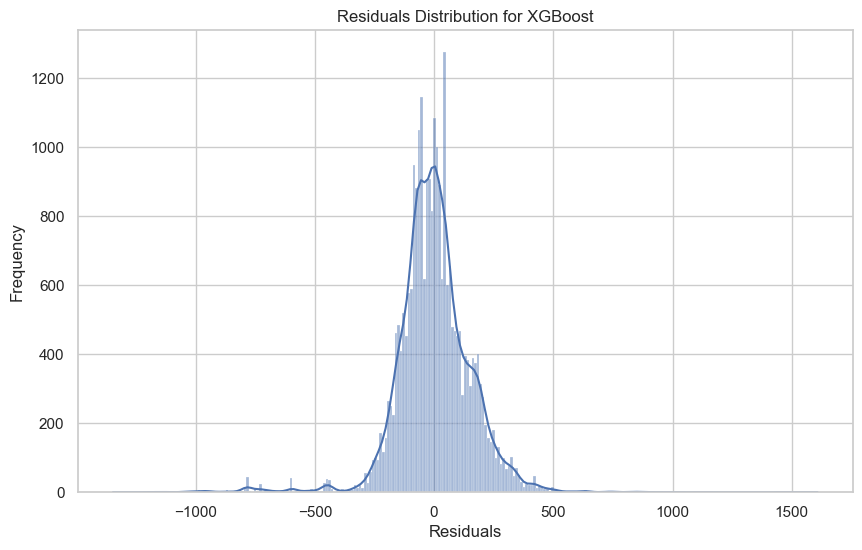

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8


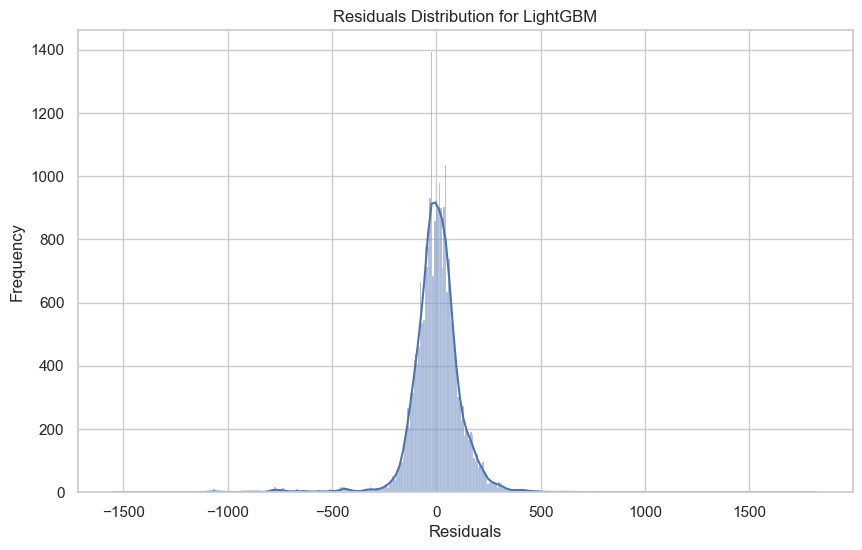

In [91]:
# Residuals for each model
plot_residuals(xgb_model, X_test, y_test, "XGBoost")
plot_residuals(lgb_model, X_test, y_test, "LightGBM")


In [92]:
# Weighted average ensemble function
def ensemble_predictions_weighted(X_test, xgb_model, lgb_model, weight_xgb=0.5, weight_lgb=0.5):
    # Predict with each model
    xgb_preds = xgb_model.predict(X_test)
    lgb_preds = lgb_model.predict(X_test)
    
    # Weighted average of predictions
    ensemble_preds = (weight_xgb * xgb_preds) + (weight_lgb * lgb_preds)
    return ensemble_preds

# Generate and evaluate weighted average ensemble predictions
ensemble_preds_weighted = ensemble_predictions_weighted(X_test, xgb_model, lgb_model)
evaluate_model(y_test, ensemble_preds_weighted)


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
Mean Absolute Error (MAE): 94.46562165416547
Root Mean Squared Error (RMSE): 141.48110729079292
R-squared (R2): 0.7356399936793439


(94.46562165416547, 141.48110729079292, 0.7356399936793439)

In [93]:
# Stacking ensemble function
def create_stacked_features(X_train, X_test, xgb_model, lgb_model):
    xgb_train_preds = xgb_model.predict(X_train)
    lgb_train_preds = lgb_model.predict(X_train)
    X_train_stack = np.column_stack((xgb_train_preds, lgb_train_preds))
    
    xgb_test_preds = xgb_model.predict(X_test)
    lgb_test_preds = lgb_model.predict(X_test)
    X_test_stack = np.column_stack((xgb_test_preds, lgb_test_preds))
    
    return X_train_stack, X_test_stack

# Generate stacked features
X_train_stack, X_test_stack = create_stacked_features(X_train, X_test, xgb_model, lgb_model)

# Train and evaluate meta-model (Linear Regression)
meta_model = LinearRegression()
meta_model.fit(X_train_stack, y_train)
stacked_preds = meta_model.predict(X_test_stack)
evaluate_model(y_test, stacked_preds)


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
Mean Absolute Error (MAE): 70.43107352735457
Root Mean Squared Error (RMSE): 125.03488631540473
R-squared (R2): 0.7935279544276145


(70.43107352735457, 125.03488631540473, 0.7935279544276145)

In [94]:
# Define the function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test, predictions, model_name):
    # Plotting actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual', marker='o')
    plt.plot(predictions, label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted Sales for {model_name}')
    plt.xlabel('Index')
    plt.ylabel('Sales Amount')
    plt.legend()
    plt.show()


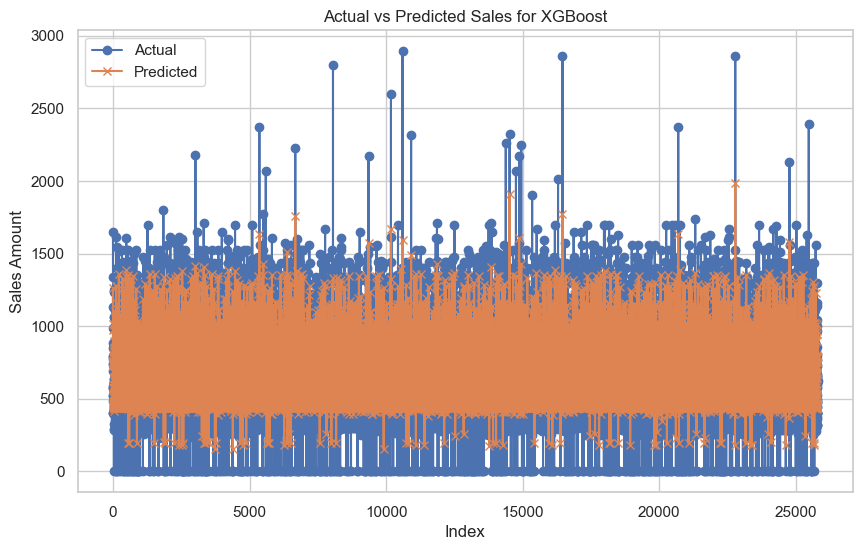

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8


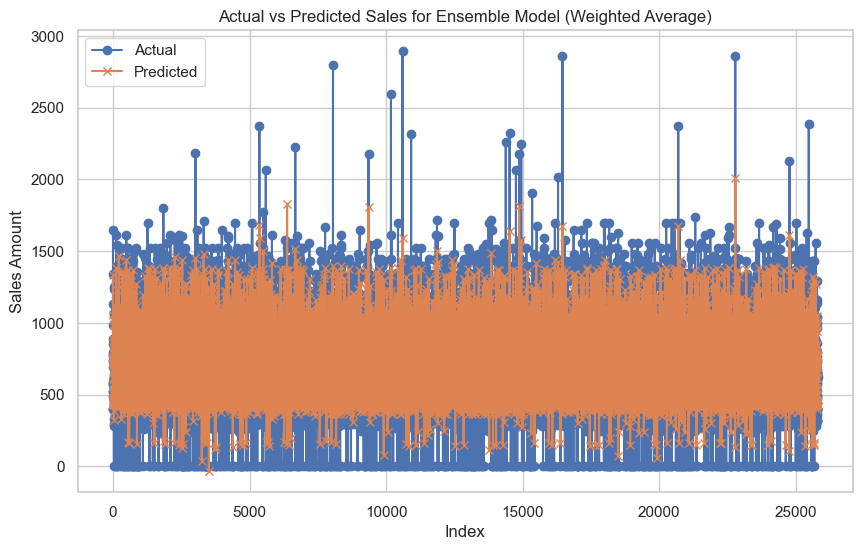

In [66]:
# Generate predictions for XGBoost
xgb_predictions = xgb_model.predict(X_test)
plot_actual_vs_predicted(y_test, xgb_predictions, "XGBoost")

# Generate predictions for the ensemble model and plot
ensemble_preds_weighted = ensemble_predictions_weighted(X_test, xgb_model, lgb_model)
plot_actual_vs_predicted(y_test, ensemble_preds_weighted, "Ensemble Model (Weighted Average)")


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8


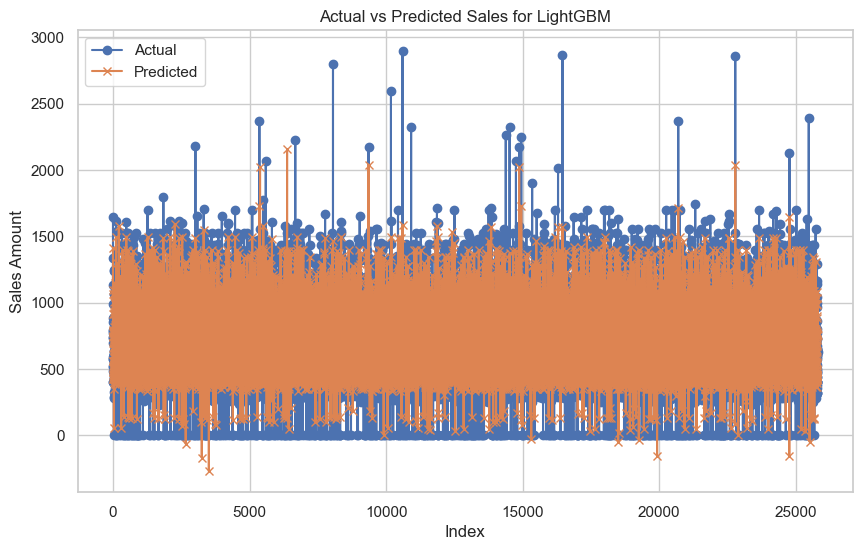

In [102]:
# Generate predictions for the LightGBM model
lgb_predictions = lgb_model.predict(X_test)

# Define a function to plot actual vs predicted values for LightGBM
def plot_actual_vs_predicted(y_test, predictions, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual', marker='o')
    plt.plot(predictions, label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted Sales for {model_name}')
    plt.xlabel('Index')
    plt.ylabel('Sales Amount')
    plt.legend()
    plt.show()

# Plot actual vs predicted for LightGBM
plot_actual_vs_predicted(y_test, lgb_predictions, "LightGBM")


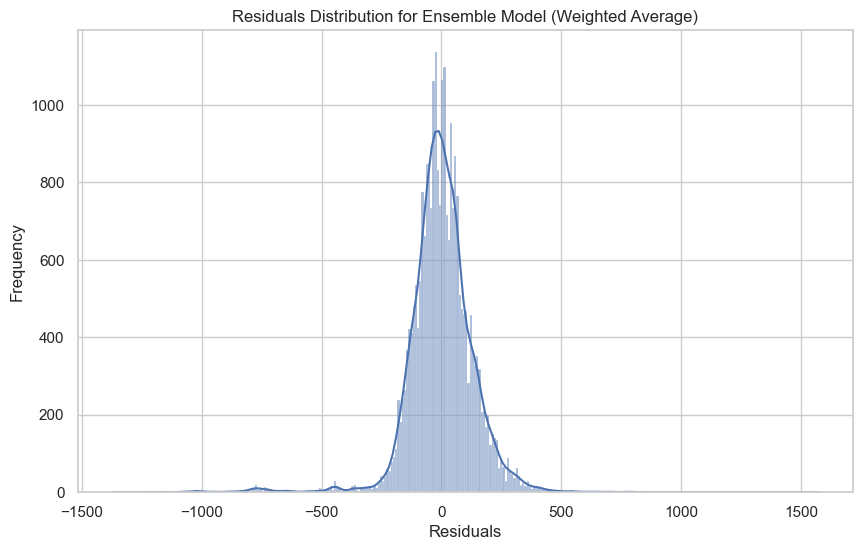

In [95]:
# Residual distribution for ensemble predictions
ensemble_residuals = y_test - ensemble_preds_weighted
plt.figure(figsize=(10, 6))
sns.histplot(ensemble_residuals, kde=True)
plt.title('Residuals Distribution for Ensemble Model (Weighted Average)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


<Figure size 1200x600 with 0 Axes>

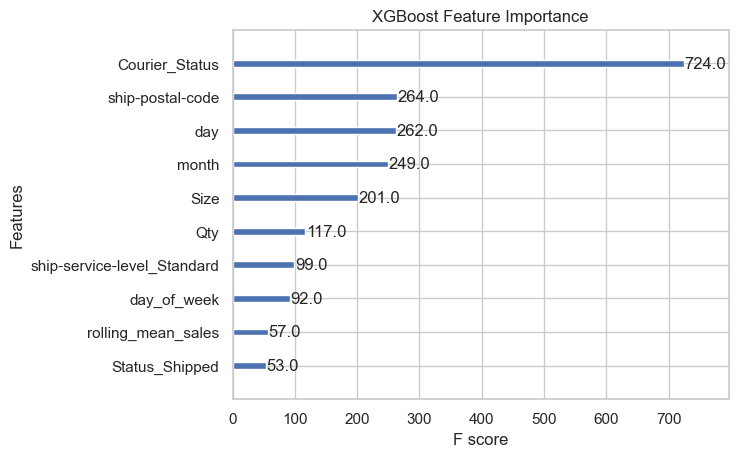

<Figure size 1200x600 with 0 Axes>

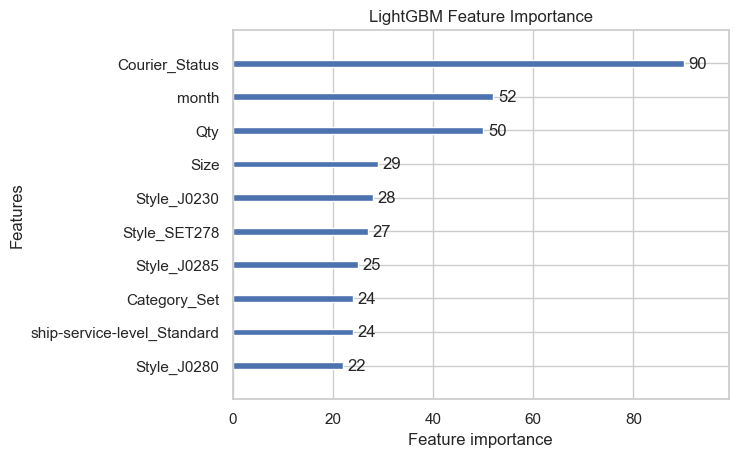

In [68]:
# XGBoost feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

# LightGBM feature importance
plt.figure(figsize=(12, 6))
lgb.plot_importance(lgb_model, max_num_features=10)
plt.title("LightGBM Feature Importance")
plt.show()


In [96]:
# Define a function to compute MAE, RMSE, and R²
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


In [97]:
# Calculate metrics for XGBoost
xgb_predictions = xgb_model.predict(X_test)
xgb_mae, xgb_rmse, xgb_r2 = calculate_metrics(y_test, xgb_predictions)

# Calculate metrics for LightGBM
lgb_predictions = lgb_model.predict(X_test)
lgb_mae, lgb_rmse, lgb_r2 = calculate_metrics(y_test, lgb_predictions)

# Display metrics
print("XGBoost Metrics:")
print(f"MAE: {xgb_mae}, RMSE: {xgb_rmse}, R2: {xgb_r2}")
print("\nLightGBM Metrics:")
print(f"MAE: {lgb_mae}, RMSE: {lgb_rmse}, R2: {lgb_r2}")


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
XGBoost Metrics:
MAE: 109.85458146980702, RMSE: 158.3238552993003, R2: 0.6689515439553113

LightGBM Metrics:
MAE: 80.53868815932645, RMSE: 129.94072633418796, R2: 0.7770079226305019


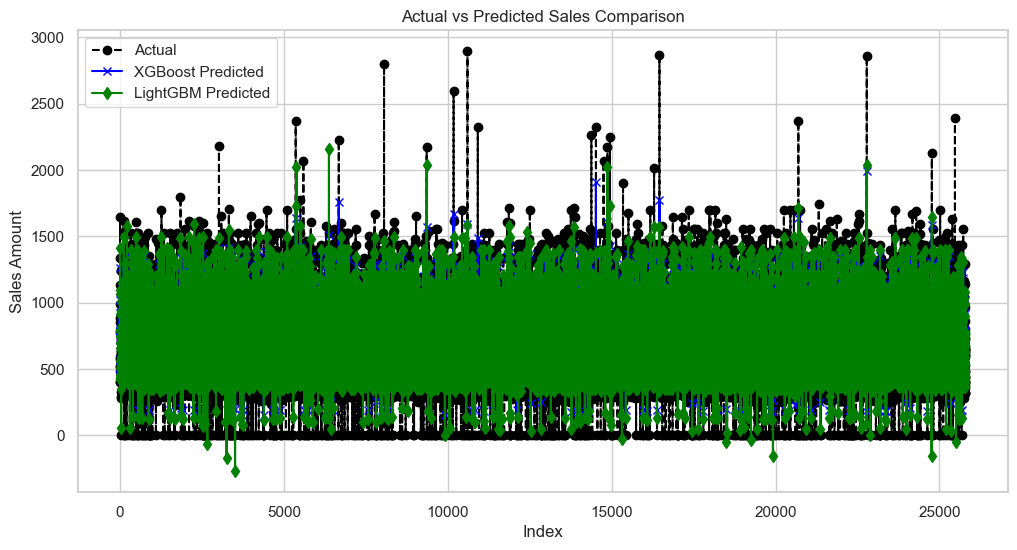

In [98]:
# Plot actual vs predicted values for both models
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', marker='o', color='black', linestyle='--')
plt.plot(xgb_predictions, label='XGBoost Predicted', marker='x', color='blue')
plt.plot(lgb_predictions, label='LightGBM Predicted', marker='d', color='green')
plt.title('Actual vs Predicted Sales Comparison')
plt.xlabel('Index')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()


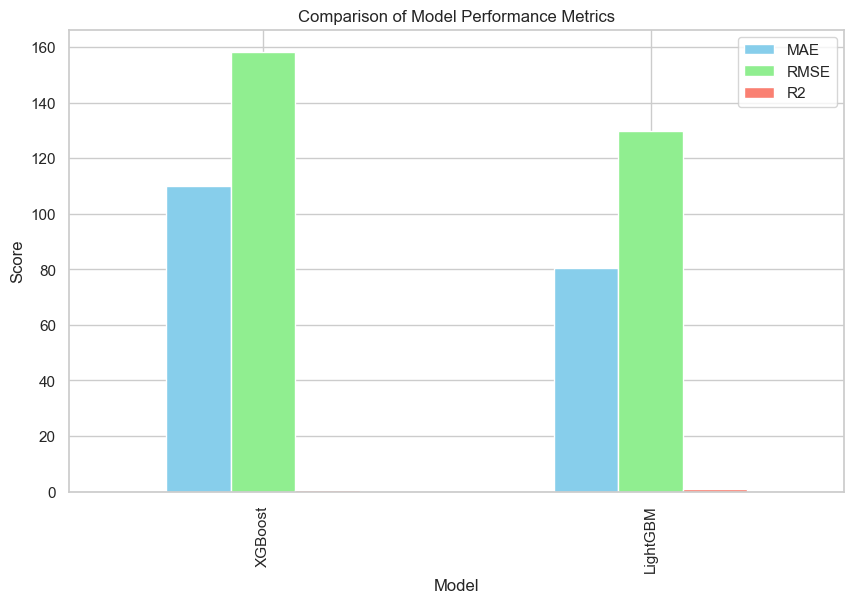

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM'],
    'MAE': [xgb_mae, lgb_mae],
    'RMSE': [xgb_rmse, lgb_rmse],
    'R2': [xgb_r2, lgb_r2]
})

# Plotting metrics for comparison
metrics_df.set_index('Model')[['MAE', 'RMSE', 'R2']].plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.show()


In [100]:
# Determine the best model based on RMSE
if xgb_rmse < lgb_rmse:
    best_model = "XGBoost"
    print("XGBoost performed better based on RMSE.")
else:
    best_model = "LightGBM"
    print("LightGBM performed better based on RMSE.")


LightGBM performed better based on RMSE.


In [101]:
# Print metrics for both models
print("XGBoost Metrics:")
print(f"MAE: {xgb_mae}, RMSE: {xgb_rmse}, R2: {xgb_r2}")
print("\nLightGBM Metrics:")
print(f"MAE: {lgb_mae}, RMSE: {lgb_rmse}, R2: {lgb_r2}\n")

# Determine the best model based on each metric
best_mae_model = "XGBoost" if xgb_mae < lgb_mae else "LightGBM"
best_rmse_model = "XGBoost" if xgb_rmse < lgb_rmse else "LightGBM"
best_r2_model = "XGBoost" if xgb_r2 > lgb_r2 else "LightGBM"  # Higher R² is better

# Display the best model for each metric
print("Best Model Based on Each Metric:")
print(f"MAE: {best_mae_model} (Lower is better)")
print(f"RMSE: {best_rmse_model} (Lower is better)")
print(f"R²: {best_r2_model} (Higher is better)")


XGBoost Metrics:
MAE: 109.85458146980702, RMSE: 158.3238552993003, R2: 0.6689515439553113

LightGBM Metrics:
MAE: 80.53868815932645, RMSE: 129.94072633418796, R2: 0.7770079226305019

Best Model Based on Each Metric:
MAE: LightGBM (Lower is better)
RMSE: LightGBM (Lower is better)
R²: LightGBM (Higher is better)
